In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[2]").appName("test").getOrCreate()

In [4]:
trace_file = "/Users/vkprabhala/Desktop/twitter-challenge/application-trace.json" 
app_trace = spark.read.json(trace_file,multiLine=True)

In [5]:
app_trace.printSchema()

root
 |-- cesMetadata: struct (nullable = true)
 |    |-- countryCode: string (nullable = true)
 |    |-- oauthAppId: long (nullable = true)
 |-- messageSequenceNumber: long (nullable = true)
 |-- name: string (nullable = true)
 |-- parentSpanId: long (nullable = true)
 |-- spanId: long (nullable = true)
 |-- startTimeMicroseconds: long (nullable = true)
 |-- stopTimeMicroseconds: long (nullable = true)
 |-- traceId: struct (nullable = true)
 |    |-- leastSignificantBits: long (nullable = true)
 |    |-- mostSignificantBits: long (nullable = true)



In [6]:
app_trace.show(4,False)

+-----------+---------------------+-----------------------+------------+-----------+---------------------+--------------------+------------------------------------------+
|cesMetadata|messageSequenceNumber|name                   |parentSpanId|spanId     |startTimeMicroseconds|stopTimeMicroseconds|traceId                                   |
+-----------+---------------------+-----------------------+------------+-----------+---------------------+--------------------+------------------------------------------+
|{BR, 234}  |255372               |time-to-fully-loaded   |null        |-2147472118|1607549809181000     |null                |{8736631216184186000, 7012058579801421000}|
|{BR, 234}  |255397               |time-to-fully-loaded   |null        |-2147472118|null                 |1607549811804000    |{8736631216184186000, 7012058579801421000}|
|{US, 234}  |255256               |loading-direct-messages|-2058295690 |-2147467911|1607549745719000     |null                |{-3946938644639398

In [7]:
app_trace.count()

884000

In [8]:
from pyspark.sql.functions import * 

In [9]:
# How many span messages are in this file?
# How many unique spans do the messages describe?
# How many traces are in this file?
app_trace.agg(count('messageSequenceNumber').alias('num_span_messages'),
              countDistinct('spanId').alias('unique_spans'),
              countDistinct('traceId').alias('num_traces'),
             ).show()

+-----------------+------------+----------+
|num_span_messages|unique_spans|num_traces|
+-----------------+------------+----------+
|           884000|      441987|     34000|
+-----------------+------------+----------+



In [10]:
#What are the distinct names of the spans we are tracking?
app_trace.select('name').distinct().show(100,False)

+----------------------------+
|name                        |
+----------------------------+
|loading-timeline-tweets     |
|authenticating-user         |
|loading-cached-tweets       |
|loading-notifications       |
|time-to-fully-loaded        |
|rendering-cached-tweets     |
|initializing-application    |
|rendering-message-count     |
|loading-direct-messages     |
|rendering-timeline-tweets   |
|finalize-application-start  |
|loading-feature-flags       |
|rendering-notification-count|
+----------------------------+



In [11]:
# What are the names of the traces?
# The root span defines the name of the trace (i.e. the name of the root span is the name of the trace)
app_trace.filter(col('parentSpanId').isNull()).select(col('name')).distinct().show(100,False)

+--------------------+
|name                |
+--------------------+
|time-to-fully-loaded|
+--------------------+



In [12]:
# What is the minimum and maximum duration of all the spans? How about average (mean) and p95?
span_durations = app_trace.groupBy(col('spanId')).agg((max('stopTimeMicroseconds') - max('startTimeMicroseconds')).alias('span_duration'))
min_max_span_durations = span_durations.agg(min('span_duration').alias('min_span_duration'),
                                            max('span_duration').alias('max_span_duration'),
                                            avg('span_duration').alias('mean_span_duration'),
                                            expr('percentile(span_duration, 0.95)').alias('p95_span_duration')
                                            )
min_max_span_durations.show(1,False)                                            

+-----------------+-----------------+------------------+-----------------+
|min_span_duration|max_span_duration|mean_span_duration|p95_span_duration|
+-----------------+-----------------+------------------+-----------------+
|-166000          |3805000          |514873.8922185494 |2365000.0        |
+-----------------+-----------------+------------------+-----------------+



In [13]:
# What is unexpected about these results, and how should we handle it for further analysis? What would you do if you saw something like this in your data?
# Some spans have startTime > stopTime which results in min_span_duration being negative. We can exclude the spans with startTime > stopTime for further analysis. 
# Also there are some spans with more than 1 pair of start and stoptime like the ones shown below 
app_trace.groupBy('spanId').count().filter(col('count') != 2).show(100,False)


+-----------+-----+
|spanId     |count|
+-----------+-----+
|1334505210 |4    |
|289675416  |4    |
|2044164616 |4    |
|-1623396131|4    |
|1388118298 |4    |
|708324914  |4    |
|571003751  |4    |
|1638074620 |4    |
|1851979998 |4    |
|781219535  |4    |
|2056622259 |4    |
|-79912640  |4    |
|495190732  |4    |
+-----------+-----+



In [14]:
# For the rest of the questions, let’s just pretend that we live in a universe where the weird data is acceptable, and include it in further analysis.
# What is the name of the span which has no children, and has the shortest duration on average? Longest duration on average?
span_with_no_child = app_trace.filter(col('parentSpanId').isNull()).select(col('name').alias('span_with_no_children')).distinct()
span_with_no_child.show(10,False)
span_durations = app_trace.groupBy('spanId','name').agg( ((max('stopTimeMicroseconds') - max('startTimeMicroseconds')).alias('span_duration') ))
avg_span_durations = span_durations.groupBy('name').agg(avg('span_duration').alias('avg_span_duration'))
shortest_avg_duration_span = avg_span_durations.orderBy('avg_span_duration').head(1)
longest_avg_duration_span = avg_span_durations.orderBy(desc('avg_span_duration')).head(1)
print(shortest_avg_duration_span)
print(longest_avg_duration_span)

+---------------------+
|span_with_no_children|
+---------------------+
|time-to-fully-loaded |
+---------------------+

[Row(name='finalize-application-start', avg_span_duration=99491.82352941176)]
[Row(name='time-to-fully-loaded', avg_span_duration=2477797.5)]


In [15]:
# you get a report that several users have said the latest version of the app (oauthAppId 234) is slower in comparison to the older version (oauthAppId 123). Other users have said the opposite, that the experience seems faster. Who is right? Why?

#When users mention one app version is faster than the other it helps to look at the average duration metric by country and app version to confirm whose report is right.
#We can compare the avg duration metric for each span by different app versions and country.
span_app_version_durations = (app_trace.groupBy('spanId',(col('cesMetadata')['oauthAppId']).alias('appVersion'),
                                               (col('cesMetadata')['countryCode']).alias('country'),
                                               'name'
                                               ) 
                                      .agg(((max('stopTimeMicroseconds') - max('startTimeMicroseconds')).alias('span_duration')))
)
avg_durations_by_version_name_country = (span_app_version_durations.groupBy('name','appVersion') 
                                                          .pivot('country',['US','BR']) 
                                                          .agg(avg('span_duration').alias('avg_span_duration'))
)
analysis = (avg_durations_by_version_name_country.
            withColumn('which_faster', when(col('US') < col('BR'), 'US Faster').otherwise('BR Faster'))
           )
analysis.orderBy(col('name')).show(100,False)
#Looking at the result column `which_faster` we can say that the avergae duration metric for different spans is varying in fastness by country for different app versions.
#If we only consider the trace `time-to-fully-loaded` based on the average duration metric 
# app version 123 was faster in BR than US
# app version 234 was faster in US than BR
# Bar plots shown below with comparisons

+----------------------------+----------+---------+----------+------------+
|name                        |appVersion|US       |BR        |which_faster|
+----------------------------+----------+---------+----------+------------+
|authenticating-user         |234       |199634.8 |199550.9  |BR Faster   |
|authenticating-user         |123       |199549.7 |199409.5  |BR Faster   |
|finalize-application-start  |123       |99193.8  |99736.25  |US Faster   |
|finalize-application-start  |234       |99609.9  |99574.0   |BR Faster   |
|initializing-application    |123       |798419.9 |797588.5  |BR Faster   |
|initializing-application    |234       |697493.4 |997710.8  |US Faster   |
|loading-cached-tweets       |123       |299921.1 |299066.0  |BR Faster   |
|loading-cached-tweets       |234       |299541.2 |299339.1  |BR Faster   |
|loading-direct-messages     |234       |298390.2 |299219.9  |US Faster   |
|loading-direct-messages     |123       |298808.0 |299096.0  |US Faster   |
|loading-fea

In [16]:
import pandas as pd 
pandas_df = analysis.toPandas()

In [17]:
pandas_df_123 = pandas_df[pandas_df['appVersion'] == 123]
pandas_df_234 = pandas_df[pandas_df['appVersion'] == 234]

<AxesSubplot:title={'center':'App Version 234'}, xlabel='name'>

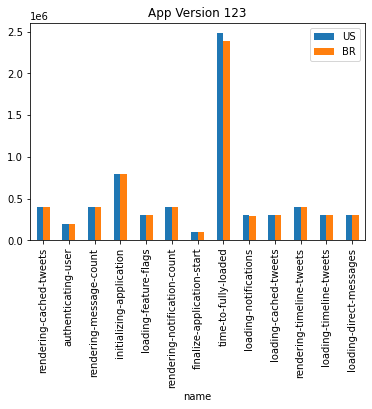

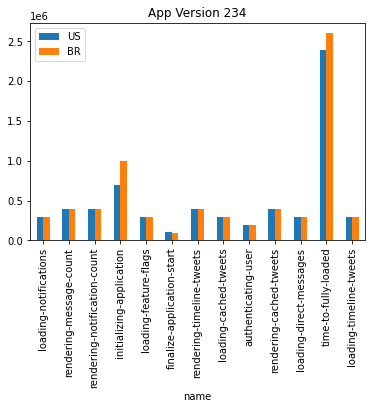

In [18]:
pandas_df_123[['name','US','BR']].plot.bar(x='name',title='App Version 123')
pandas_df_234[['name','US','BR']].plot.bar(x='name',title='App Version 234')